In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from scikeras.wrappers import KerasClassifier

In [21]:
dt = pd.read_csv(r"C:\Users\sebex\Desktop\Magisterka\magisterka_implementacja\data\ECGCvdata.csv")
dt.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [22]:
# Drop "RECORD" column, which is redundant index
dt.drop(labels=["RECORD"], axis=1, inplace=True)
dt.head()

,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,PTseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,0.301905,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,0.289670,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,0.219088,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,0.296962,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,0.296345,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [23]:
def fill_attr_with_lr(data: pd.DataFrame, attr_with_na: str, attr_without_na: str) -> None:
    """Fill attribute with empty records with linear regression using attribute
    without empty records.

    Parameters
    ----------
    data: pd.DataFrame
        DataFrame which includes involved attributes in the operation.
    attr_with_na: str
        Name of attribute with empty values to be filled.
    attr_without_na: str
        Name of attribute without empty values, needed to find linear regression factors.

    """
    tmp_dt = data[[attr_with_na, attr_without_na]].dropna(axis=0)
    a, b = np.polyfit(tmp_dt[attr_without_na], tmp_dt[attr_with_na], 1)
    data[attr_with_na].fillna(a * data[attr_without_na] + b, inplace=True)

In [24]:
fill_attr_with_lr(dt, "RSslope", "QRSperi")
fill_attr_with_lr(dt, "QRSang", "PPmean")
fill_attr_with_lr(dt, "RSTang", "PTdis")
fill_attr_with_lr(dt, "QRtoQSdur", "NNTot")
fill_attr_with_lr(dt, "PQRang", "PonTdis")
fill_attr_with_lr(dt, "PonPQang", "PonRdis")
fill_attr_with_lr(dt, "STToffang", "SToffdis")
fill_attr_with_lr(dt, "QRslope", "QRSang")
fill_attr_with_lr(dt, "RStoQSdur", "QRtoQSdur")

In [25]:
# Convert determining attribute from string to decimal 
le = LabelEncoder()
dt["ECG_signal"] = le.fit_transform(dt["ECG_signal"])
le.classes_

array(['AFF', 'ARR', 'CHF', 'NSR'], dtype=object)

In [26]:
X = dt.drop(["ECG_signal"], axis=1)
y = dt["ECG_signal"]

# Merge all columns with distance to one attribute
# distances = []
# for col in dt.columns:
#     if col.endswith("dis"):
#         distances.append(col)

# X_dis = X[distances]
# X = X.drop(distances, axis=1)

# pca_dis = PCA(n_components=1)
# X_dis_n_1 = pd.DataFrame({"Distances_PCA": pca_dis.fit_transform(X)[:, 0]})
# X = pd.concat([X, X_dis_n_1], axis=1)

# Merge all columns with segment to one attribute
# segments = []
# for col in dt.columns:
#     if col.endswith("seg"):
#         segments.append(col)

# X_seg = X[segments]
# X = X.drop(segments, axis=1)

# pca_seg = PCA(n_components=1)
# X_seg_n_1 = pd.DataFrame({"Segments_PCA": pca_seg.fit_transform(X)[:, 0]})
# X = pd.concat([X, X_seg_n_1], axis=1)

# Standarization with 0-1 scale
X = (X - X.min()) / (X.max() - X.min())

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X,
                                                                y,
                                                                test_size=0.20,
                                                                stratify=y,
                                                                shuffle=True,
                                                                random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                      y_train_valid,
                                                      test_size=0.20,
                                                      shuffle=True,
                                                      stratify=y_train_valid,
                                                      random_state=42)

In [27]:
X

,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,PTseg,...,SDSD,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50
0,0.420396,0.744997,0.636931,0.734471,0.667477,0.838939,0.765986,0.608827,0.584427,0.769824,...,0.015279,0.162753,0.557110,0.734782,0.958341,0.511075,0.796139,0.028271,0.054054,0.111562
1,0.376898,0.690425,0.511170,0.781655,0.708777,0.843156,0.816964,0.548483,0.331626,0.707822,...,0.005139,0.181294,0.695519,0.782976,0.926436,0.532337,0.775419,0.051082,0.027027,0.061179
2,0.478394,0.672411,0.416457,0.328978,0.284779,0.300114,0.358974,0.471634,0.364017,0.350126,...,0.064352,0.149250,0.324661,0.337893,0.826980,0.603970,0.342131,0.121113,0.432432,0.798548
3,0.376898,0.830469,0.629715,0.752036,0.692819,0.801433,0.773810,0.535378,0.326316,0.744774,...,0.006024,0.177400,0.719721,0.753418,0.942293,0.551888,0.740634,0.056493,0.054054,0.122358
4,0.468853,0.667074,0.575009,0.840741,0.756999,0.845148,0.884712,0.468630,0.312147,0.741649,...,0.034459,0.142234,0.632121,0.841220,0.947681,0.484259,0.823088,0.051184,0.054054,0.102516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.531925,0.403967,0.177869,0.159372,0.153980,0.171643,0.155978,0.540689,0.315768,0.154796,...,0.000804,0.015860,0.000000,0.002545,0.114029,0.810375,0.002577,0.358022,0.000000,0.000000
1196,0.329057,0.485340,0.168440,0.509832,0.480183,0.314533,0.512848,0.238069,0.342868,0.231325,...,0.001422,0.044423,0.248808,0.262112,0.504589,0.962934,0.145337,0.663657,0.000000,0.000000
1197,0.545001,0.506653,0.639385,0.673566,0.617378,0.617274,0.696592,0.404593,0.325093,0.644871,...,0.001357,0.014622,0.230105,0.258504,0.814258,0.940882,0.205591,0.358800,0.027027,0.011635
1198,0.344662,0.541527,0.561601,0.680702,0.630514,0.419687,0.696592,0.136826,0.282839,0.492537,...,0.002810,0.041304,0.259998,0.265585,0.779970,0.982834,0.139429,0.672670,0.243243,0.104718


In [28]:
# Model referencyjny - sięć głęboka złożona z samych warstw gęstych Fully Connected

# dostosowanie danych wejściowych pod model referencyjny

inputs = keras.Input(shape=(54,))

x = layers.Dense(64, activation="relu")(inputs)
x = keras.layers.Dropout(rate=0.4)(x)

x = layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(rate=0.4)(x)

x = layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(rate=0.4)(x)

x = layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(rate=0.4)(x)

x = layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(rate=0.4)(x)

outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="ecg_hf_classification.keras",
        save_best_only=True,
        monitor="val_loss"),
        keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        monitor='loss',
        patience=10)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=50,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks)

# Evaluating the model on the test set
test_model = keras.models.load_model("ecg_hf_classification.keras")
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3062 - loss: 1.3489 - val_accuracy: 0.6719 - val_loss: 0.8140
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5873 - loss: 0.8839 - val_accuracy: 0.7240 - val_loss: 0.5962
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6672 - loss: 0.6931 - val_accuracy: 0.7240 - val_loss: 0.5918
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6783 - loss: 0.6681 - val_accuracy: 0.8542 - val_loss: 0.3563
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7634 - loss: 0.4959 - val_accuracy: 0.8802 - val_loss: 0.3272
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7776 - loss: 0.4641 - val_accuracy: 0.8698 - val_loss: 0.3151
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8342 - loss: 0.3853 - val_accuracy: 0.8906 - val_loss: 0.2606
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8416 - loss: 0.3706 - val_accuracy: 0.

In [37]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,722 (5.39 MB)

 Trainable params: 705,860 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 705,862 (2.69 MB)

In [29]:
y_pred = model.predict(X_test)
is_correct = 0
for i in range(len(X_test)):
    print(f"Prediction is: {np.argmax(y_pred[i])}, Right answer is: {y_test.iloc[i]}")
    if np.argmax(y_pred[i]) == y_test.iloc[i]:
        is_correct += 1
# define the KerasClassifier object and use it in cross_val_predict
# keras_clf = KerasClassifier(model = test_model, optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"], epochs=100, batch_size=50, verbose=0, callbacks=callbacks)
# print(f"cross val score: {round(np.mean(cross_val_score(keras_clf, X_valid, y_valid, cv=4, scoring='accuracy')) * 100, 2)} %")
accuracy = round(is_correct / len(X_test) * 100, 2)
print(f"Accuracy of test data predicting is: {accuracy} %")
print(f"Accuracy_score: {round(accuracy_score(y_test, list(map(np.argmax, y_pred))) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test, list(map(np.argmax, y_pred))) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, list(map(np.argmax, y_pred)), average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, list(map(np.argmax, y_pred)), average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, list(map(np.argmax, y_pred)), average="macro") * 100, 2)} %')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Prediction is: 0, Right answer is: 0
Prediction is: 2, Right answer is: 2
Prediction is: 3, Right answer is: 3
Prediction is: 1, Right answer is: 1
Prediction is: 3, Right answer is: 3
Prediction is: 0, Right answer is: 0
Prediction is: 1, Right answer is: 1
Prediction is: 1, Right answer is: 1
Prediction is: 0, Right answer is: 0
Prediction is: 2, Right answer is: 2
Prediction is: 1, Right answer is: 1
Prediction is: 3, Right answer is: 3
Prediction is: 1, Right answer is: 1
Prediction is: 1, Right answer is: 1
Prediction is: 2, Right answer is: 2
Prediction is: 2, Right answer is: 2
Prediction is: 2, Right answer is: 2
Prediction is: 2, Right answer is: 2
Prediction is: 0, Right answer is: 0
Prediction is: 2, Right answer is: 0
Prediction is: 3, Right answer is: 3
Prediction is: 3, Right answer is: 3
Prediction is: 3, Right answer is: 3
Prediction is: 2, Right answer is: 2
Prediction is: 2, Right answer is: 2
Prediction is: 3, Right answer is: 3
P

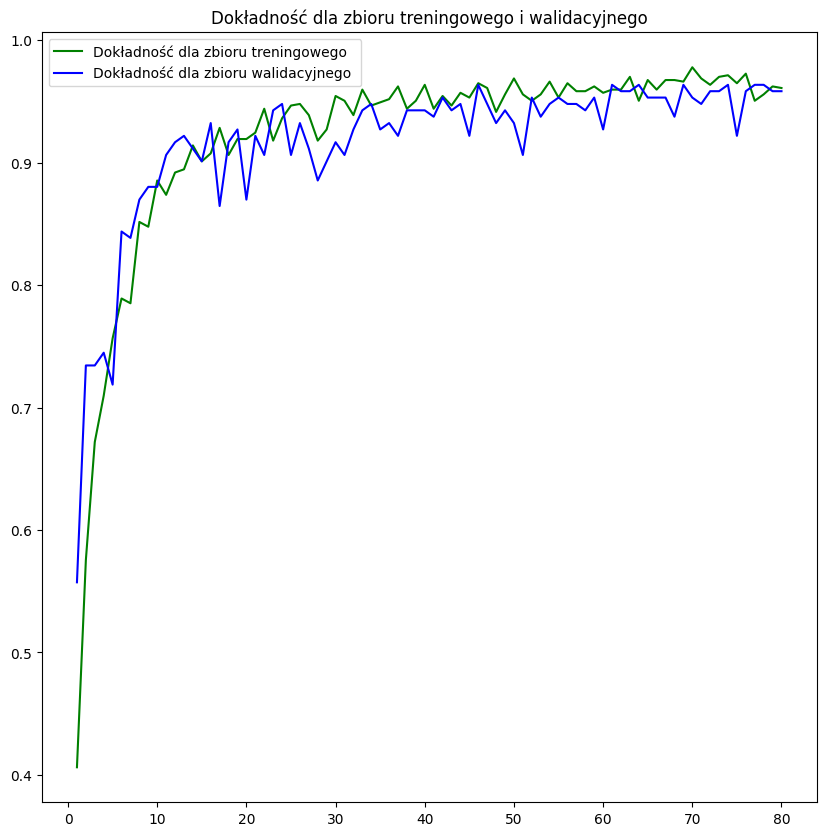

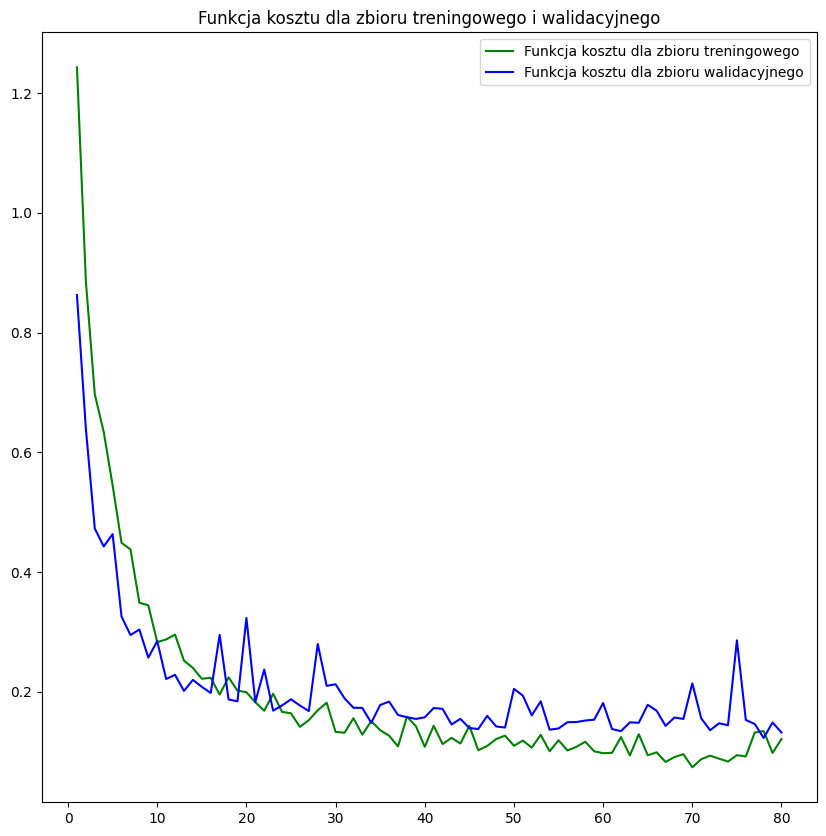

In [14]:
# Wykres diagnostyczny dla modelu referyncyjnego

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, accuracy, "g", label="Dokładność dla zbioru treningowego ")
plt.plot(epochs, val_accuracy, "b", label="Dokładność dla zbioru walidacyjnego ")
plt.title("Dokładność dla zbioru treningowego i walidacyjnego")
plt.legend()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "g", label="Funkcja kosztu dla zbioru treningowego")
plt.plot(epochs, val_loss, "b", label="Funkcja kosztu dla zbioru walidacyjnego")
plt.title("Funkcja kosztu dla zbioru treningowego i walidacyjnego")
plt.legend()
plt.show()

In [25]:
# Define possibilities for model tuner | Definiowanie możliwości do rozpatrzenia dla tunera modelu

def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [128, 256, 512, 1024, 2048]),
      activation='relu'))
  if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

  model.add(keras.layers.Dense(
      hp.Choice('units', [128, 256, 512, 1024, 2048]),
      activation='relu'))
  if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

  model.add(keras.layers.Dense(
      hp.Choice('units', [128, 256, 512, 1024, 2048]),
      activation='relu'))
  if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

  model.add(keras.layers.Dense(
      hp.Choice('units', [128, 256, 512, 1024, 2048]),
      activation='relu'))
  if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

#   model.add(keras.layers.Dense(
#       hp.Choice('units', [128, 256, 512, 1024]),
#       activation='relu'))
#   if hp.Boolean("dropout"):
#         model.add(layers.Dropout(rate=0.50))

  model.add(keras.layers.Dense(4, activation="softmax"))

  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
  return model

In [26]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    overwrite = True)

tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512, 1024, 2048], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [27]:
# Find best model | Szukanie najlepszego modelu
tuner.search(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),  batch_size=50)
best_model = tuner.get_best_models()[0]

Trial 35 Complete [00h 02m 44s]
val_loss: 0.10694050043821335

Best val_loss So Far: 0.06635555624961853
Total elapsed time: 00h 38m 44s


C:\Users\sebex\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
# Build the model. Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 54))
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       112,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,709,892 (48.48 MB)

 Trainable params: 12,709,892 (48.48 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
units: 2048
dropout: False
learning_rate: 0.001
Score: 0.06635555624961853

Trial 25 summary
Hyperparameters:
units: 128
dropout: False
learning_rate: 0.01
Score: 0.08712494373321533

Trial 27 summary
Hyperparameters:
units: 1024
dropout: False
learning_rate: 0.001
Score: 0.09217983484268188

Trial 07 summary
Hyperparameters:
units: 512
dropout: False
learning_rate: 0.001
Score: 0.09223455935716629

Trial 02 summary
Hyperparameters:
units: 2048
dropout: True
learning_rate: 0.001
Score: 0.09414594620466232

Trial 10 summary
Hyperparameters:
units: 256
dropout: False
learning_rate: 0.01
Score: 0.09829006344079971

Trial 23 summary
Hyperparameters:
units: 128
dropout: False
learning_rate: 0.001
Score: 0.09940401464700699

Trial 01 summary
Hyperparameters:
units: 1024
dropout: False
learning_rate: 0.0001
Score: 0.10119769722223282

Trial 32 sum

In [30]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hp.
tuned_model = build_model(best_hps[0])

# Fit with the entire dataset.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="ECG_HF_detection_best_tuned.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        monitor='loss',
        patience=5)]

history = tuned_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=50,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks)

# Evaluate the model on the test set | Ewaluacja modelu na zestawie danych testowych
test_tuned_model = keras.models.load_model("ECG_HF_detection_best_tuned.keras")
test_loss, test_acc = test_tuned_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.3825 - loss: 1.2898 - val_accuracy: 0.6562 - val_loss: 0.6912
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.5903 - loss: 0.9207 - val_accuracy: 0.7604 - val_loss: 0.3844
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.7236 - loss: 0.5958 - val_accuracy: 0.7656 - val_loss: 0.3820
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8285 - loss: 0.3732 - val_accuracy: 0.8438 - val_loss: 0.3215
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8775 - loss: 0.2949 - val_accuracy: 0.7708 - val_loss: 0.4988
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8194 - loss: 0.4836 - val_accuracy: 0.8177 - val_loss: 0.3557
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9143 - loss: 0.2121 - val_accuracy: 0.7604 - val_loss: 0.5802
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8823 - loss: 0.2885 - val_accuracy

In [31]:
test_tuned_model.get_build_config()

{'input_shape': (None, 54)}

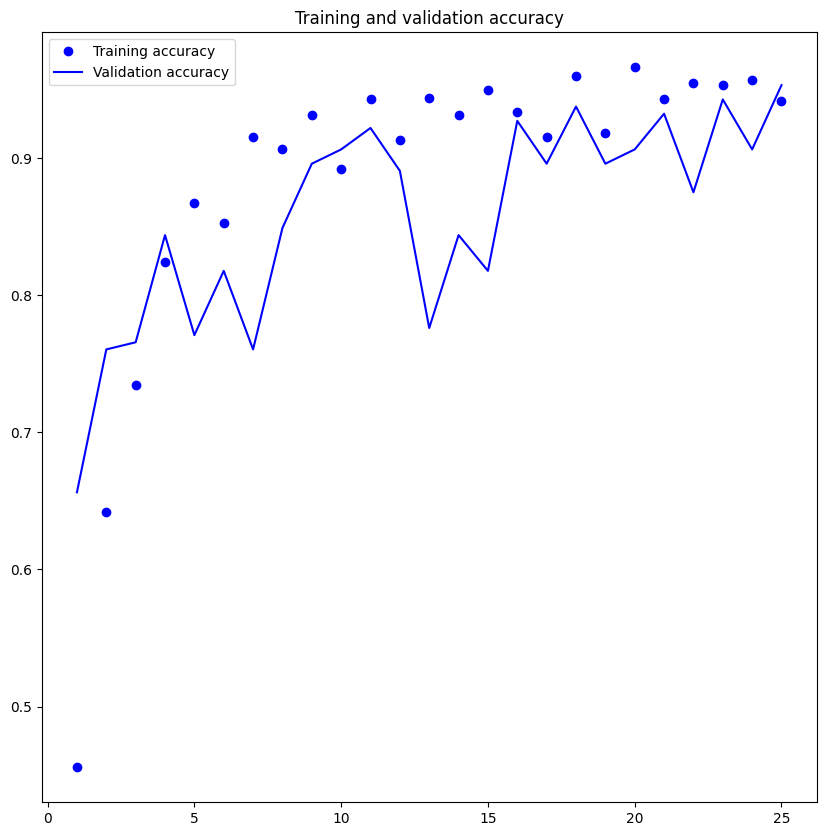

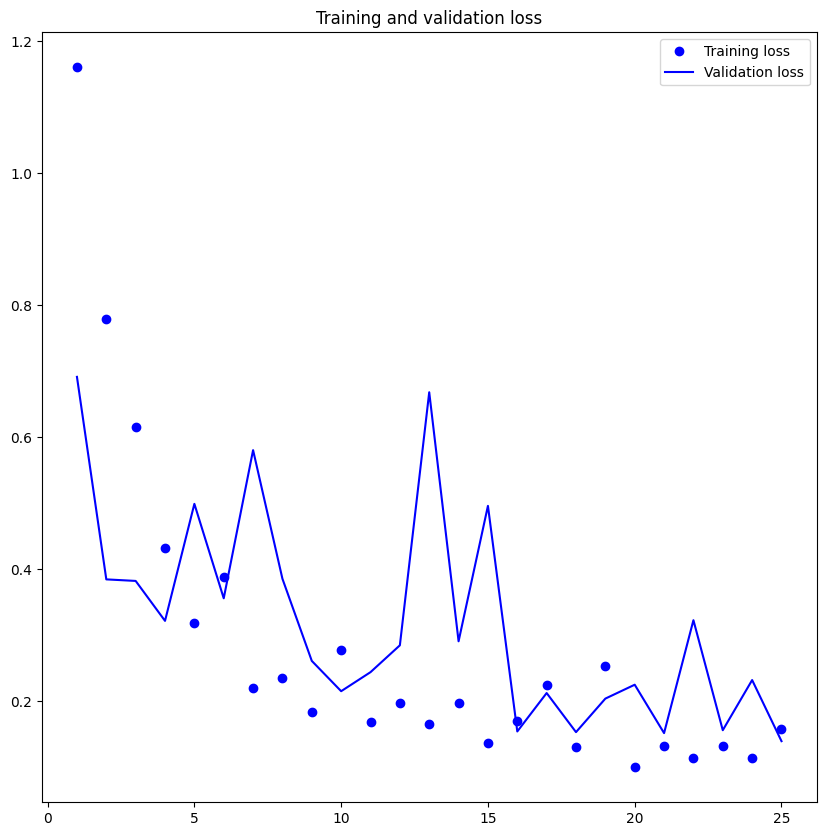

In [33]:
# Wykres diagnostyczny dla modelu referyncyjnego

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
# Define Decision Tree Classifier parameters to be tested by Grid Search CV
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("ccp_alphas: \n", ccp_alphas) 

# Find best Decision Tree Classifier model parameters via Grid Search CV
parameters = {'ccp_alpha': ccp_alphas, 'max_depth': list(range(1, 10, 1)), 'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(clf, parameters)
gsc.fit(X_valid, y_valid)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")

ccp_alphas: 
 [0.         0.00130208 0.00195312 0.00230593 0.00231481 0.00234375
 0.00244094 0.00252279 0.00259067 0.00474318 0.0067034  0.00767696
 0.00797356 0.01045974 0.01588955 0.03150655 0.13971716 0.24806207
 0.25      ]
Best params: {'ccp_alpha': 0.0, 'max_depth': 5, 'max_leaf_nodes': 6}
Best score: 0.9322537112010796


In [ ]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

parameters = {'ccp_alpha': ccp_alphas,
              'max_depth': list(range(1, 10, 1)),
              'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(clf, parameters)
gsc.fit(X_valid, y_valid)

clf = DecisionTreeClassifier(random_state=42,
                             ccp_alpha=gsc.best_params_["ccp_alpha"],
                             max_depth=gsc.best_params_["max_depth"],
                             max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")

In [10]:
# Train best Desicion Tree Classifier model
clf = DecisionTreeClassifier(random_state=42,
                             ccp_alpha=gsc.best_params_["ccp_alpha"],
                             max_depth=gsc.best_params_["max_depth"],
                             max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
print(f"cross val score: {cross_val_score(clf, X_valid, y_valid, cv=4)}")
print(f"mean: {np.mean(cross_val_score(clf, X_valid, y_valid, cv=4))}")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f'F1_score: {f1_score(y_test, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro")}')

is_correct = 0
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")
    if yp == yt:
        is_correct += 1
accuracy = round(is_correct / len(X_test) * 100, 2)
print(f"Accuracy of test data predicting is: {accuracy} %")

cross val score: [0.9375     0.89583333 0.91666667 0.95833333]
mean: 0.9270833333333334
Accuracy: 0.9458333333333333
F1_score: 0.9458271645269887
Recall: 0.9458333333333333
Precision: 0.9466643897996356
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 3, actual 

In [ ]:
# Train best Desicion Tree Classifier model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"cross val score: {round(np.mean(cross_val_score(clf, X_valid, y_valid, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred, average="macro") * 100, 2)} %')

is_correct = 0
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")
    if yp == yt:
        is_correct += 1
accuracy = round(is_correct / len(X_test) * 100, 2)
print(f"Accuracy of test data predicting is: {accuracy} %")

export_graphviz(
  clf,
  out_file="file.dot",
  feature_names=X.columns,
  class_names=le.classes_,
  rounded=True,
  filled=True
 )

cross val score: 93.23 %
Accuracy_score: 95.0 %
Accuracy: 95.0 %
F1_score: 94.96 %
Recall: 95.0 %
Precision: 95.01 %
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, 

In [12]:
# Train Random Forest Classifier model
rfc = RandomForestClassifier(random_state=42, max_leaf_nodes=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"cross val score: {np.mean(cross_val_score(rfc, X_valid, y_valid, cv=4))}")
print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f'F1_score: {f1_score(y_test, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro")}')
is_correct = 0
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")
    if yp == yt:
        is_correct += 1
accuracy = round(is_correct / len(X_test) * 100, 2)
print(f"Accuracy of test data predicting is: {accuracy} %")

cross val score: 0.9531250000000001
Accuracy_score: 0.9625
Accuracy: 0.9625
F1_score: 0.962288193966111
Recall: 0.9625
Precision: 0.9622744669218153
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 0,

In [39]:
# Find best Random Forest Classifier model parameters via Grid Search CV
rfc = RandomForestClassifier(random_state=42)
parameters = {'ccp_alpha': list(np.arange(0, 0.5, 0.05)), 'max_depth': list(range(1, 10, 1)), 'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(rfc, parameters)
gsc.fit(X_valid, y_valid)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")

Best params: {'ccp_alpha': 0.0, 'max_depth': 6, 'max_leaf_nodes': 8}
Best score: 0.9476383265856949


In [40]:
# Train best Random Forest Classifier model
rfc = RandomForestClassifier(random_state=42,
                             ccp_alpha=gsc.best_params_["ccp_alpha"],
                             max_depth=gsc.best_params_["max_depth"],
                             max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"cross val score: {np.mean(cross_val_score(rfc, X_valid, y_valid, cv=4))}")
print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f'F1_score: {f1_score(y_test, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro")}')
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 0.9427083333333334
Accuracy_score: 0.9666666666666667
Accuracy: 0.9666666666666667
F1_score: 0.966523108270816
Recall: 0.9666666666666667
Precision: 0.9666481275491288
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Predictio

In [ ]:
rfc = RandomForestClassifier(random_state=42, n_estimators=1000)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(f"cross val score: {round(np.mean(cross_val_score(rfc, X_valid, y_valid, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 95.83 %
Accuracy_score: 97.5 %
Accuracy: 97.5 %
F1_score: 97.49 %
Recall: 97.5 %
Precision: 97.49 %
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, 

In [ ]:
clf = LogisticRegression(random_state=42, C=1000.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(f"cross val score: {round(np.mean(cross_val_score(clf, X_valid, y_valid, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 93.23 %
Accuracy_score: 98.75 %
Accuracy: 98.75 %
F1_score: 98.75 %
Recall: 98.75 %
Precision: 98.81 %
Prediction: 2, actual value: 0
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 3, actual value: 3
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 3, actual value: 3
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 

c:\Users\sebex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sebex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st